In [68]:
import dlib
from skimage import io, transform
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import openface
%matplotlib inline

## Step 1 : Find faces

In [103]:
filename = './data/test/563.jpg'
filename = './data/thiago-silva/pic_00003.jpg'

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
# Load the image into an array
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run the HOG face detector on the image data.
# The result will be the bounding boxes of the faces in our image.
detected_faces = face_detector(image, 1)

## Step 2: Affine transformations

In [104]:
face_detector = dlib.get_frontal_face_detector()
# To get face landmark estimation
face_pose_predictor = dlib.shape_predictor('./data/model/shape_predictor_68_face_landmarks.dat')
# To align faces
face_aligner = openface.AlignDlib('./data/model/shape_predictor_68_face_landmarks.dat')
detected_faces = face_detector(image, 1)

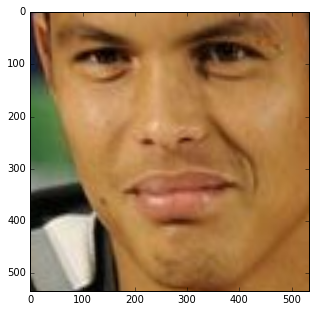

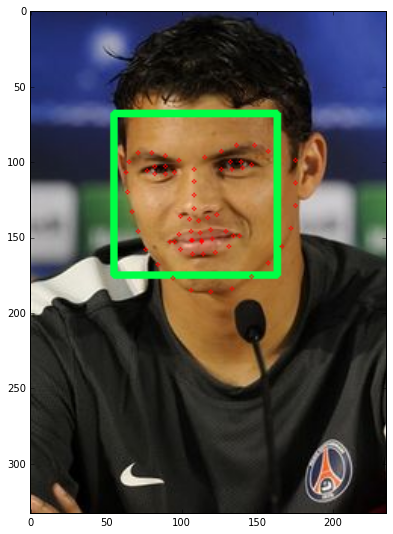

In [105]:
img = np.copy(image)
f, ax = plt.subplots(ncols=len(detected_faces), figsize=(5,5))
for i, f in enumerate(detected_faces):
    cv2.rectangle(img, (f.left(), f.top()), (f.right(), f.bottom()), (0,255,70), 3)

    # Get the the face's pose
    pose_landmarks = face_pose_predictor(img, f)
    for p in pose_landmarks.parts():
        cv2.circle(img, (p.x, p.y), 1, (255,0,0))

    alignedFace = face_aligner.align(534, image, f, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
    ax.imshow(alignedFace)
    
plt.figure(figsize=map(lambda x:int(x/25), img.shape[:2]))
plt.imshow(img)

## Step 3 : Encoding faces

In [27]:
face_recognition_model = face_recognition_models.face_recognition_model_location()
#face_recognition_model = 'dlib_face_recognition_resnet_model_v1.dat'
face_encoder = dlib.face_recognition_model_v1(face_recognition_model)

In [36]:
face_encoding = np.array(face_encoder.compute_face_descriptor(image, pose_landmarks, 1))

In [56]:
a = np.array(face_encoder.compute_face_descriptor(image, pose_landmarks, 1))

### Step 4 : Training 

In [75]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [ ]:
characters = ['cavani',
 'thiago-silva',
 'marquinhos']
face_detector = dlib.get_frontal_face_detector()
face_recognition_model = face_recognition_models.face_recognition_model_location()
face_encoder = dlib.face_recognition_model_v1(face_recognition_model)
df = pd.DataFrame()

for char in characters:
    l = []
    for filename in glob.glob('./data/%s/*' % char):
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        detected_faces = face_detector(image, 1)
        face_detect = detected_faces[0]
        pose_landmarks = face_pose_predictor(image, face_detect)
        face_encoding = np.array(face_encoder.compute_face_descriptor(image, pose_landmarks, 1))
        l.append(np.append(face_encoding, [char]))
    temp = pd.DataFrame(np.array(l))
    df = pd.concat([df, temp])
df.reset_index(drop=True, inplace=True)

In [78]:
le = LabelEncoder()
y = le.fit_transform(df[128])
print("Training for {} classes.".format(len(le.classes_)))
X = df.drop(128, axis=1)
print('{} columns for X'.format(len(X.columns)))

Training for 4 classes.
128 columns for X


In [81]:
clf = SVC(C=1, kernel='linear', probability=True)
clf.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

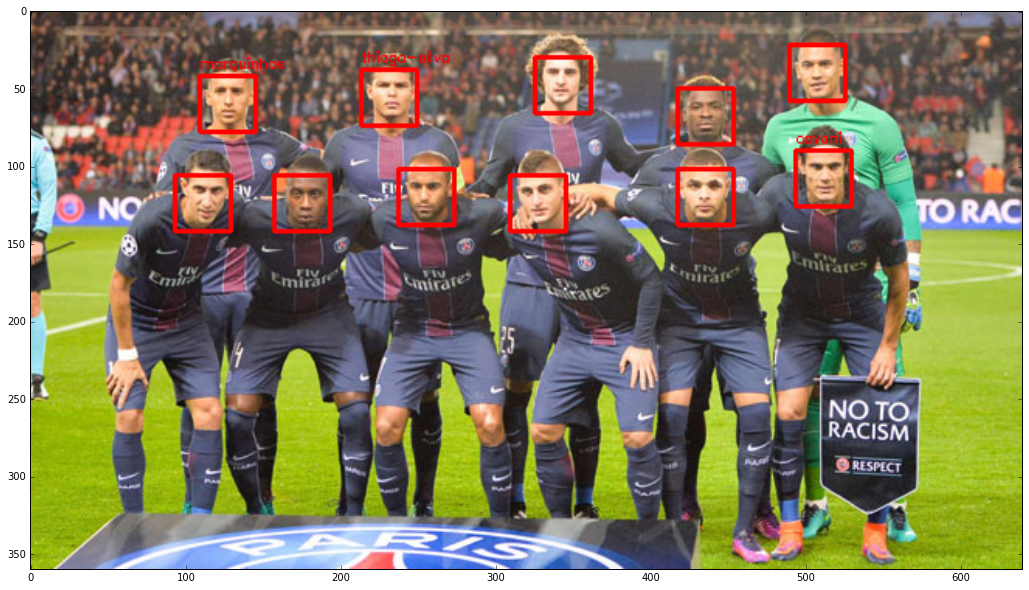

In [100]:
font = cv2.FONT_HERSHEY_SIMPLEX
image = cv2.imread('./test/563.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = np.copy(image)
detected_faces = face_detector(image, 1)
for face_detect in detected_faces:
    cv2.rectangle(img, (face_detect.left(), face_detect.top()), 
                      (face_detect.right(), face_detect.bottom()), (255, 0, 0), 2)
    pose_landmarks = face_pose_predictor(image, face_detect)
    face_encoding = np.array(face_encoder.compute_face_descriptor(image, pose_landmarks, 1))
    p = clf.predict_proba(face_encoding.reshape(1, 128))
    if np.max(p) > 0.8:
        y_pred = le.inverse_transform(np.argmax(p))
        cv2.putText(img, y_pred, (face_detect.left(), face_detect.top()-5), font, 0.3, (255, 0, 0))
plt.figure(figsize=(20,10))
plt.imshow(img)